#  (Nguyen Tuong Ha - nguyenpanda)
- Dataset link: [Kaggle]()

# Table of Contents
<!-- TOC -->
* [(Nguyen Tuong Ha - nguyenpanda)](#nguyen-tuong-ha---nguyenpanda)
* [Table of Contents](#table-of-contents)
* [0. Setup](#0-setup)
  * [0.0. Install packages](#00-install-packages)
  * [0.1. Checking running environment](#01-checking-running-environment)
    * [Download dataset from Kaggle](#download-dataset-from-kaggle)
    * [Creating a symbolic link (alias) to an exist directory](#creating-a-symbolic-link-alias-to-an-exist-directory)
<!-- TOC -->

# 0. Setup

## 0.0. Install packages

In [ ]:
!pip install nguyenpanda kaggle torchmetrics torchinfo mlxtend

In [1]:
import torch
import torchvision

from torch import nn
from torch import optim
from torchmetrics import ConfusionMatrix
from torch.utils import data as torch_data
from torch.utils.data import DataLoader, Dataset, random_split
from torch.utils.data.dataloader import default_collate

from torchvision import datasets
from torchvision import transforms

from torchinfo import summary

In [2]:
import albumentations as A
import numpy as np
import pandas as pd
import mlxtend as mle
import cv2
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
import nguyenpanda
from nguyenpanda.swan import color, green, yellow
import nguyenpanda.crow as crow
from PIL import Image
from IPython import display
from tqdm.notebook import tqdm
from mlxtend.plotting import plot_confusion_matrix
from pathlib import Path

import os
import sys
import importlib
import random
import typing_extensions as te

In [4]:
from autoencoder import AutoencoderCSVDataset, AutoencoderDirValidationDataset

## 0.1. Checking running environment

In [5]:
DEVICE = ('cuda' if torch.cuda.is_available() else
          'mps' if torch.backends.mps.is_available() else
          'cpu')
print('DEVICE:', green(DEVICE))

CPUs = os.cpu_count()
print('CPUs:', green(CPUs))

# print(plt.style.available)
plt.style.use('dark_background')

IN_COLAB: bool = crow.nbu.is_colab()
MY_DRIVE: te.Optional[Path] = crow.gcu.mount_google_drive()

DEVICE: cpu
CPUs: 8


### Creating a symbolic link (alias) to an exist directory

In [6]:
# For creating a symbolic link (alias) to an existing directory
dataset: crow.Dataset = crow.Dataset(
    name='MNIST'  # By default: None
)

dataset: crow.Dataset = dataset.alias(
    source=crow.Dataset.bfs_find('MNIST_CSV', search_path=Path.home()),
    # By default: `source` is None (if None, alias name is '<dataset-alias-name>' provided at Dataset constructor
    # Either `name` or `source` must be provided, else a ValueError is raised. 
    destination=Path.cwd(),  # By default: Path.cwd()
    verbose=True,  # By default: True
)

DATASET_SOURCE_DIR: Path = dataset.dataset_source_dir

Creating an alias /Users/hatuongnguyen/datasets/MNIST_CSV -> /Users/hatuongnguyen/Learning/PyTorch/model/MNIST_ShortCut/MNIST


In [7]:
train_transform = transforms.Compose([
    transforms.ToTensor(),
])

test_transform = transforms.Compose([
    transforms.ToTensor(),
])

In [11]:
train_dataset = AutoencoderCSVDataset(DATASET_SOURCE_DIR / 'train.csv', train_transform)
test_dataset = AutoencoderCSVDataset(DATASET_SOURCE_DIR / 'test.csv', test_transform)

print(len(train_dataset), len(test_dataset))

60000 10000


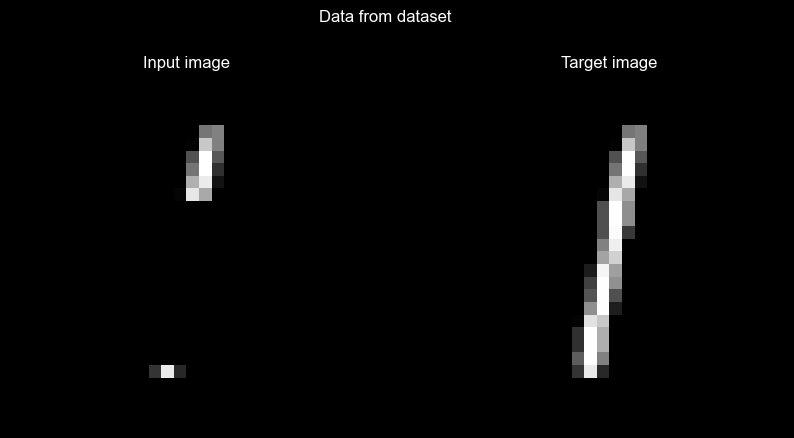

In [12]:
data = train_dataset[random.randint(0, 10000)]

fig = plt.figure(figsize=(10, 5))

fig.suptitle('Data from dataset')

ax = plt.subplot(1, 2, 1)
ax.imshow(data[0].squeeze().to('cpu'), cmap='gray')
ax.set_title('Input image')
ax.axis('off')

ax = plt.subplot(1, 2, 2)
ax.imshow(data[1].squeeze().to('cpu'), cmap='gray')
ax.set_title('Target image')
ax.axis('off')

plt.show()

In [13]:
def collate_func(batch_list):
    return tuple(_tensor.to(DEVICE) for _tensor in default_collate(batch_list))


BATCH_SIZE = 32
train_loader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, collate_fn=collate_func)
test_loader = DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, collate_fn=collate_func)

batch = next(iter(train_loader))
print(type(batch), len(batch))
print(batch[0].shape)
print(batch[1].shape)

<class 'tuple'> 2
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])


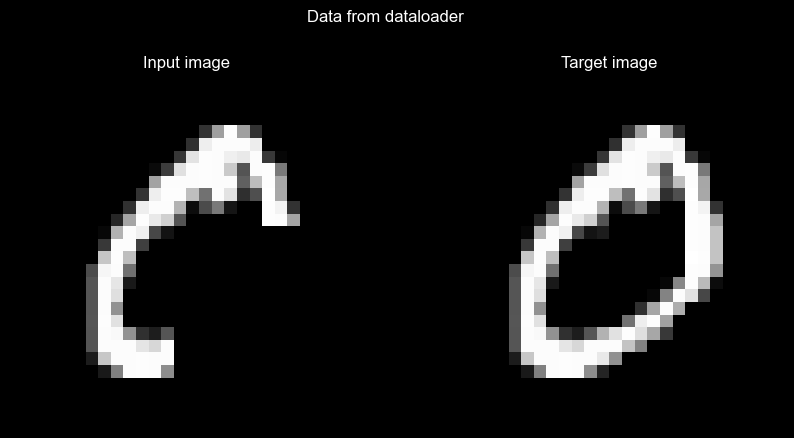

In [14]:
idx = random.randint(0, 31)

fig = plt.figure(figsize=(10, 5))

fig.suptitle('Data from dataloader')

ax = plt.subplot(1, 2, 1)
data = batch[0][idx]
ax.imshow(data[0].squeeze().to('cpu'), cmap='gray')
ax.set_title('Input image')
ax.axis('off')

ax = plt.subplot(1, 2, 2)
data = batch[1][idx]
ax.imshow(data[0].squeeze().to('cpu'), cmap='gray')
ax.set_title('Target image')
ax.axis('off')

plt.show()

In [52]:
class Conv(nn.Module):

    def __init__(self, c1, c2, k, s, p):
        super().__init__()
        self.cv = nn.Sequential(
            nn.Conv2d(c1, c2, k, s, p),
            nn.BatchNorm2d(c2),
            nn.ReLU(),
        )

    def forward(self, x):
        return self.cv(x)


class ReNet(nn.Module):
    def __init__(self, c1, k, s, p, short_cut=False):
        super().__init__()
        self.cv1 = Conv(c1=c1, c2=c1, k=k, s=s, p=p)
        self.cv2 = Conv(c1=c1, c2=c1, k=k, s=s, p=p)
        self.short_cut = short_cut

    def forward(self, x):
        out = self.cv1(x)
        out = self.cv2(out)
        return out + x if self.short_cut else out


class MNISTAutoencoder(nn.Module):

    def __init__(self):
        super().__init__()
        self.train_call = 0
        self.encoder = nn.Sequential(
            Conv(1, 64, k=7, s=1, p=3),
            ReNet(64, k=3, s=1, p=1, short_cut=True),
            Conv(64, 32, k=3, s=2, p=1),
            ReNet(32, k=3, s=1, p=1, short_cut=True),
            Conv(32, 16, k=3, s=2, p=1),
            ReNet(16, k=3, s=1, p=1, short_cut=True),
        )
        
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(16, 32, kernel_size=3, stride=2, padding=1, output_padding=1),
            ReNet(32, k=3, s=1, p=1, short_cut=True),
            nn.ConvTranspose2d(32, 64, kernel_size=3, stride=2, padding=1, output_padding=1),
            ReNet(64, k=3, s=1, p=1, short_cut=True),
            nn.ConvTranspose2d(64, 1, kernel_size=7, stride=1, padding=3),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.decoder(self.encoder(x))

    def test_step(self, dataloader, loss_function):
        total_batch = len(dataloader)
        total_loss = 0

        self.eval()
        with torch.inference_mode():
            for b, (x, y) in enumerate(dataloader, 1):
                logit = self.forward(x)
                loss = loss_function(logit, y)

                total_loss += loss.item()
        return total_loss / total_batch

    def train_step(self, dataloader, loss_function, optimizer):
        self.train_call += 1
        total_batch = len(dataloader)
        b_pad = len(str(total_batch))
        total_loss = 0

        self.train()
        for b, (x, y) in enumerate(dataloader, 1):
            logit = self.forward(x)

            loss = loss_function(logit, y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

            text = '{: >{}}/{} | ins_loss = \033[1;92m{: >10.5f}\033[0m'
            if IN_COLAB:
                text = '\r' + text
            else:
                text = text + '\r'
            print(text.format(b, b_pad, total_batch, loss.item()), end='')
        print()

        return total_loss / total_batch


In [53]:
generator = iter(train_loader)
test_model = MNISTAutoencoder().to(DEVICE)
_x, _y = next(generator)
print(green(f'(x, y) shape:'), _x.shape, _y.shape)

logit = test_model(_x)
logit.shape

(x, y) shape: torch.Size([32, 1, 28, 28]) torch.Size([32, 1, 28, 28])


torch.Size([32, 1, 28, 28])

In [54]:
def wrap_value(value):
    return green(f'{value: >8.5f}')


EPOCHS = 50
LEARNING_RATE = 5e-4
HIDDEN_CHANNEL = 40

history = dict(train_loss=[], test_loss=[])
model = MNISTAutoencoder().to(DEVICE)

loss_func = nn.BCEWithLogitsLoss()
opti = optim.Adam(params=model.parameters(), lr=LEARNING_RATE)

print('EPOCHS:', green(EPOCHS))
print('LEARNING_RATE:', green(LEARNING_RATE))
print('loss_func:', green(loss_func))
print('opti:', green(opti.__class__.__name__))

summary(model, input_size=(BATCH_SIZE, 1, 28, 28))

EPOCHS: 50
LEARNING_RATE: 0.0005
loss_func: BCEWithLogitsLoss()
opti: Adam


Layer (type:depth-idx)                        Output Shape              Param #
MNISTAutoencoder                              [32, 1, 28, 28]           --
├─Sequential: 1-1                             [32, 16, 7, 7]            --
│    └─Conv: 2-1                              [32, 64, 28, 28]          --
│    │    └─Sequential: 3-1                   [32, 64, 28, 28]          3,328
│    └─ReNet: 2-2                             [32, 64, 28, 28]          --
│    │    └─Conv: 3-2                         [32, 64, 28, 28]          37,056
│    │    └─Conv: 3-3                         [32, 64, 28, 28]          37,056
│    └─Conv: 2-3                              [32, 32, 14, 14]          --
│    │    └─Sequential: 3-4                   [32, 32, 14, 14]          18,528
│    └─ReNet: 2-4                             [32, 32, 14, 14]          --
│    │    └─Conv: 3-5                         [32, 32, 14, 14]          9,312
│    │    └─Conv: 3-6                         [32, 32, 14, 14]          9,312

In [55]:
MODEL_FILE_NAME = 'zip_unzip.pt'
MODEL_PATH: Path = Path('/content/drive/MyDrive/Colab Notebooks/zip_unzip') if IN_COLAB else Path(Path.cwd() / 'parameter')

In [56]:
_max_test_loss: float = -1

for e in tqdm(range(1, EPOCHS + 1), desc='Epoch: ', total=EPOCHS):
    train_loss = model.train_step(train_loader, loss_func, opti)
    test_loss = model.test_step(test_loader, loss_func)
    print('train_loss = {} | test_loss = {}'.format(
        wrap_value(train_loss), wrap_value(test_loss),
    ))

    history['train_loss'].append(train_loss)
    history['test_loss'].append(test_loss)

    if _max_test_loss <= test_loss:
        _max_test_loss = test_loss

        if not MODEL_PATH.is_dir():
            MODEL_PATH.mkdir(parents=True, exist_ok=True)
        torch.save(model.state_dict(), MODEL_PATH / MODEL_FILE_NAME)

Epoch:   0%|          | 0/50 [00:00<?, ?it/s]

KeyboardInterrupt: 